In [2]:
import os

import random

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import datetime

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.summary.summary_iterator import summary_iterator



In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\wasim\\Desktop\\ML Projects\\species_reg\\dogs_usecase'

In [4]:

dataset_dir = os.path.join(current_dir, "dataset")


animal_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]


train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')



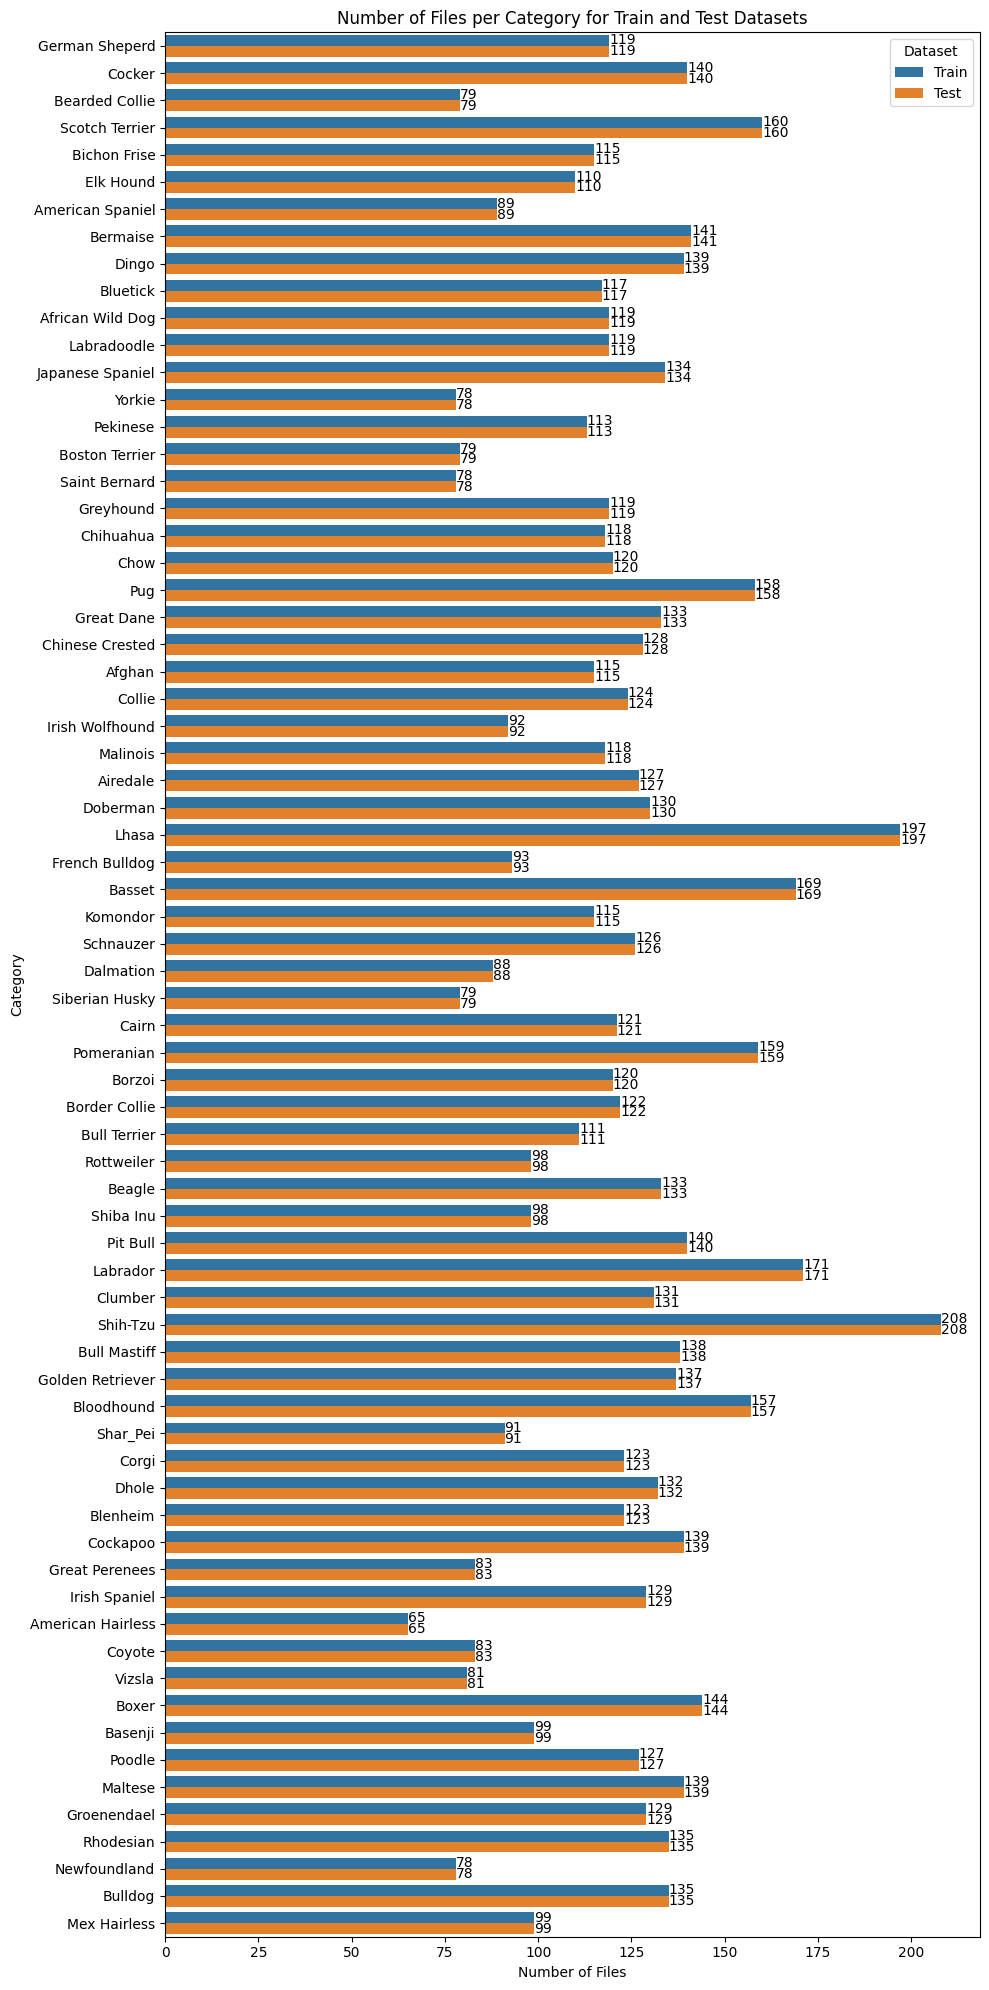

In [62]:
def count_files_in_categories(directory):
    category_counts = {}
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            category_counts[category] = len(os.listdir(category_path))
    return category_counts

train_counts = count_files_in_categories(train_dir)
test_counts = count_files_in_categories(test_dir)

all_categories = set(train_counts.keys()).union(test_counts.keys())

data = {
    "Category": list(all_categories),
    "Train Count": [train_counts.get(cat, 0) for cat in all_categories],
    "Test Count": [test_counts.get(cat, 0) for cat in all_categories],
}

df_combined = pd.DataFrame(data)

total_train_files = sum(train_counts.values())
total_test_files = sum(test_counts.values())

df_melted = df_combined.melt(id_vars='Category', value_vars=['Train Count', 'Test Count'], var_name='Dataset', value_name='Count')

df_melted['Dataset'] = df_melted['Dataset'].replace({'Train Count': 'Train', 'Test Count': 'Test'})

plt.figure(figsize=(10, 20))
ax = sns.barplot(y='Category', x='Count', hue='Dataset', data=df_melted, dodge=True)

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('Number of Files')
plt.ylabel('Category')
plt.title('Number of Files per Category for Train and Test Datasets')
plt.tight_layout()
plt.show()

In [63]:
num_classes = 70
img_size = (224, 224)
batch_sz = 32
lr = 0.01
num_epochs = 10

In [64]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_data_gen = ImageDataGenerator(rescale=1./255)

base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=["accuracy"])


In [65]:
train_gen = train_data_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_sz,
    class_mode="categorical"
)

val_gen = val_data_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_sz,
    class_mode="categorical"
)

steps_per_epoch = train_gen.samples // batch_sz
val_steps = val_gen.samples // batch_sz

log_directory = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_directory, histogram_freq=1)

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=[tensorboard_cb]
)

model.save("classification_model.h5")

Found 8456 images belonging to 70 classes.
Found 8456 images belonging to 70 classes.
Epoch 1/10
264/264 [==============================] - 798s 3s/step - loss: 1.5858 - accuracy: 0.7532 - val_loss: 0.6309 - val_accuracy: 0.8250
Epoch 2/10
264/264 [==============================] - 843s 3s/step - loss: 0.7327 - accuracy: 0.8206 - val_loss: 0.5748 - val_accuracy: 0.8459
Epoch 3/10
264/264 [==============================] - 1079s 4s/step - loss: 0.6740 - accuracy: 0.8392 - val_loss: 0.4503 - val_accuracy: 0.8786
Epoch 4/10
264/264 [==============================] - 950s 4s/step - loss: 0.6449 - accuracy: 0.8428 - val_loss: 0.6953 - val_accuracy: 0.8168
Epoch 5/10
264/264 [==============================] - 965s 4s/step - loss: 0.6588 - accuracy: 0.8392 - val_loss: 0.4443 - val_accuracy: 0.8827
Epoch 6/10
264/264 [==============================] - 947s 4s/step - loss: 0.6140 - accuracy: 0.8558 - val_loss: 0.4824 - val_accuracy: 0.8602
Epoch 7/10
264/264 [==============================] - 9

c:\Users\wasim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
